In [38]:
import numpy as np
import polars as pl
import os
from pathlib import Path
from typing import List, Tuple, Union
from datetime import datetime, timedelta
from pydantic import BaseModel
from loguru import logger
from enum import Enum
import random


class EndStatus(Enum):
    DISSIPATED = 0
    MOVE_OUT_OF_RESPONSIBILITY = 1
    MERGED = 2
    NEARLY_STATIONARY = 3


class CycloneCategory(Enum):
    BELOW_TD_OR_UNKNOWN = 0
    TROPICAL_DEPRESSION = 1  # 热带低压 (TD, 10.8-17.1m/s)
    TROPICAL_STORM = 2  # 热带风暴 (TS, 17.2-24.4 m/s)
    SEVERE_TROPICAL_STORM = 3  # 强热带风暴 (STS, 24.5-32.6 m/s)
    TYPHOON = 4  # 台风 (TY, 32.7-41.4 m/s)
    SEVERE_TYPHOON = 5  # 强台风 (STY, 41.5-50.9 m/s)
    SUPER_TYPHOON = 6  # 超强台风 (SuperTY, ≥51.0 m/s)
    EXTRATROPICAL = 9  # 变性 (The change is complete)


class HurricaneHeader(BaseModel):
    data_type: int
    country_code: int
    data_count: int
    hurricane_code: int
    china_hurricane_code: int
    end_status: EndStatus
    time_interval_hr: int
    hurricane_name: str
    dataset_record_time: datetime


class HurricaneEntry(BaseModel):
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


class Hurricane(BaseModel):
    header: HurricaneHeader
    entries: List[HurricaneEntry]


script_folder = Path(os.getcwd())
dataset_folder = script_folder / "CMABSTdata"

# https://tcdata.typhoon.org.cn/zjljsjj.html
# example_file = dataset_folder / "CH2022BST.txt"
example_file = dataset_folder / "CH1950BST.txt"
logger.info(f"example_file: {example_file}")


def parse_header(line: str) -> HurricaneHeader:
    entry = line.split()
    data_type = int(entry[0])
    country_code = int(entry[1])
    data_count = int(entry[2])
    hurricane_code = int(entry[3])
    try:
        china_hurricane_code = int(entry[4])
    except ValueError:
        # might be a tuple (a,b)
        codes = entry[4].split(",")
        china_hurricane_code = int(codes[0])
    hurricane_end_enum = int(entry[5])
    end_status = EndStatus(hurricane_end_enum)
    time_interval_hr = int(entry[6])
    hurricane_name = entry[7]
    dataset_record_time = entry[8]
    time_format = "%Y%m%d"
    dataset_record_time = datetime.strptime(dataset_record_time, time_format)
    return HurricaneHeader(data_type=data_type,
                           country_code=country_code,
                           data_count=data_count,
                           hurricane_code=hurricane_code,
                           china_hurricane_code=china_hurricane_code,
                           end_status=end_status,
                           time_interval_hr=time_interval_hr,
                           hurricane_name=hurricane_name,
                           dataset_record_time=dataset_record_time)


def parse_entry(line: str) -> HurricaneEntry:
    entry = line.split()
    date_str = entry[0]
    time_format = "%Y%m%d%H"
    date = datetime.strptime(date_str, time_format)
    category = int(entry[1])
    hurricane_category = CycloneCategory(category)
    latitude = float(int(entry[2])) / 10.0
    longitude = float(int(entry[3])) / 10.0
    # in hPa
    lowest_pressure = int(entry[4])
    # 2分钟平均近中心最大风速(MSW, m/s)
    # WND=9 表示 MSW < 10m/s,
    # WND=0 为缺测
    wind_speed = int(entry[5])
    # not sure about OWD
    return HurricaneEntry(date=date,
                          category=hurricane_category,
                          latitude=latitude,
                          longitude=longitude,
                          lowest_pressure=lowest_pressure,
                          wind_speed=wind_speed)


def parse_dataset(filename: str | Path):
    hurricanes: list[Hurricane] = []
    with open(filename, "r") as f:
        try:
            while True:
                # check if the line is empty
                l = f.readline()
                if not l:
                    break
                header = parse_header(l)
                count = header.data_count
                hurricane_entries = []
                for i in range(count):
                    entry = parse_entry(f.readline())
                    hurricane_entries.append(entry)
                hurricane = Hurricane(header=header, entries=hurricane_entries)
                hurricanes.append(hurricane)
        except ValueError as e:
            logger.error(f"ValueError: {e} for {filename}")
        except IndexError as e:
            logger.warning(f"IndexError: {e} for {filename}")
        except EOFError:
            logger.info(f"EOFError for {filename}")
    return hurricanes



2024-04-25 01:45:05.034 | INFO     | __main__:<module>:63 - example_file: /home/crosstyan/code/hurricane_stuff/CMABSTdata/CH1950BST.txt


In [39]:
total_dataset: list[Hurricane] = []

for file in dataset_folder.glob("*.txt"):
    hurricanes = parse_dataset(file)
    total_dataset.extend(hurricanes)

logger.info(f"total_dataset: {len(total_dataset)}")

2024-04-25 01:45:06.505 | INFO     | __main__:<module>:7 - total_dataset: 2469


In [40]:
class FlatHurricaneEntry(BaseModel):
    sample_id: int
    name: str
    china_hurricane_code: int
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


def flat_hurricane_entries(
        hurricanes: list[Hurricane]) -> List[FlatHurricaneEntry]:
    counter = 0
    def flat_one(h: Hurricane, counter: int = counter):
        name = h.header.hurricane_name
        hurricane_code = h.header.hurricane_code
        entries = h.entries
        return [
            FlatHurricaneEntry(sample_id=counter,
                               name=name,
                               china_hurricane_code=hurricane_code,
                               date=e.date,
                               category=e.category,
                               latitude=e.latitude,
                               longitude=e.longitude,
                               lowest_pressure=e.lowest_pressure,
                               wind_speed=e.wind_speed) for e in entries
        ]

    entries = []
    for h in hurricanes:
        entries.extend(flat_one(h, counter))
        counter += 1
    return entries


flatten_entries = [
    e.model_dump() for e in flat_hurricane_entries(total_dataset)
]


def entry_enum_to_number(entry: dict[str, any]) -> dict[str, any]:
    entry['category'] = entry['category'].value
    return entry


flatten_entries_without_enum = [
    entry_enum_to_number(e) for e in flatten_entries
]

In [41]:
df = pl.DataFrame(flatten_entries_without_enum)

In [42]:
df.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",71705.0,"""71705""",71705.0,"""71705""",71705.0,71705.0,71705.0,71705.0,71705.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1231.50288,null,17.650066,"""1983-09-15 19:…",2.821588,20.902251,134.228423,986.340004,23.758218
"""std""",706.358165,null,10.47291,null,2.330128,9.283707,16.616481,20.931241,15.36339
"""min""",0.0,"""(nameless)""",1.0,"""1949-01-13 00:…",0.0,0.5,95.0,870.0,0.0
"""25%""",625.0,null,9.0,"""1965-09-21 06:…",1.0,14.2,121.8,980.0,15.0
"""50%""",1223.0,null,17.0,"""1981-08-21 00:…",2.0,19.3,132.5,995.0,20.0
"""75%""",1839.0,null,25.0,"""2001-09-03 06:…",4.0,25.8,145.0,1001.0,33.0
"""max""",2468.0,"""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1022.0,110.0


In [43]:
lat_q = df["latitude"].quantile(0.98)
df_filtered = df.filter(pl.col("wind_speed") != 0).filter(
    pl.col("longitude") <= 180).filter(pl.col("latitude") <= lat_q)
df_filtered.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",64747.0,"""64747""",64747.0,"""64747""",64747.0,64747.0,64747.0,64747.0,64747.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1248.173012,null,17.529013,"""1985-06-29 06:…",2.801829,20.406011,132.944987,984.873832,25.960832
"""std""",699.189218,null,10.429097,null,2.037505,8.213721,15.601901,21.201008,14.245518
"""min""",0.0,"""(nameless)""",1.0,"""1949-01-15 00:…",0.0,0.5,95.0,870.0,8.0
"""25%""",657.0,null,9.0,"""1968-02-29 06:…",1.0,14.4,121.0,975.0,15.0
"""50%""",1235.0,null,17.0,"""1984-10-08 06:…",2.0,19.3,131.5,992.0,20.0
"""75%""",1847.0,null,25.0,"""2002-10-26 18:…",4.0,25.3,143.4,1000.0,35.0
"""max""",2468.0,"""Zola""",53.0,"""2022-12-13 06:…",9.0,45.0,180.0,1016.0,110.0


In [44]:
df_group:pl.DataFrame = df_filtered.group_by("name").agg(pl.col("name").count().alias("count"))
display(df_group.sort("count", descending=True))

name,count
str,u32
"""(nameless)""",7645
"""Faye""",551
"""Irma""",465
"""Bess""",440
"""Dinah""",438
…,…
"""Amy(-)3""",2
"""Olga(-)1""",2
"""Irma(-)1""",2


In [45]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [46]:
# px.histogram(df_group.to_pandas(), x="count", title="Number of records per hurricane")

In [47]:
names_gt_100 = df_group.filter(pl.col("count") > 100).select("name")
# names_gt_100.describe()
df_gt_100 = df_filtered.filter(pl.col("name").is_in(names_gt_100)).filter(pl.col("name") != "(nameless)")
df_gt_100.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",34782.0,"""34782""",34782.0,"""34782""",34782.0,34782.0,34782.0,34782.0,34782.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1239.195618,null,18.307487,"""1977-06-04 03:…",3.119861,20.275668,133.771215,981.929561,28.87436
"""std""",709.508363,null,11.067995,null,2.030922,8.330471,14.931498,22.472803,15.423509
"""min""",24.0,"""Abby""",1.0,"""1949-01-15 00:…",0.0,2.0,95.0,870.0,9.0
"""25%""",589.0,null,9.0,"""1964-05-25 06:…",1.0,14.1,123.0,970.0,15.0
"""50%""",1244.0,null,18.0,"""1974-03-15 12:…",3.0,19.1,132.5,990.0,25.0
"""75%""",1864.0,null,27.0,"""1986-08-22 12:…",4.0,25.2,143.8,998.0,38.0
"""max""",2466.0,"""Wynne""",53.0,"""2022-11-03 00:…",9.0,45.0,180.0,1016.0,110.0


In [48]:
df_grp = df_filtered.group_by("sample_id").agg(pl.col("sample_id").count().alias("count"))
df_grp = df_grp.sort("count", descending=True)
display(df_grp.describe())

statistic,sample_id,count
str,f64,f64
"""count""",2469.0,2469.0
"""null_count""",0.0,0.0
"""mean""",1234.0,26.223977
"""std""",712.88323,13.942594
"""min""",0.0,1.0
"""25%""",617.0,15.0
"""50%""",1234.0,25.0
"""75%""",1851.0,35.0
"""max""",2468.0,92.0


In [49]:
px.histogram(df_grp.to_pandas(), x="count")

In [50]:
# px.histogram(df_gt_100.group_by("name").agg(pl.col("name").count().alias("count")).to_pandas(), x="count", title="Number of records per hurricane")

In [51]:
# find the top 100 count of sample_id
df_sample_top_100 = df_grp.head(100)

In [52]:
import pmdarima as pm
from pmdarima.arima import StepwiseContext

def create_model(series:pl.Series, 
                    max_steps:int=256, 
                    max_dur:int=120,
                    test_percentage:float=0.2,
                 ) -> Tuple[pm.arima.ARIMA, pl.Series, pl.Series]:
    total = len(series)
    div = int(total * (1-test_percentage))
    train, test = series[:div], series[div:]
    with StepwiseContext(max_steps=max_steps):
        with StepwiseContext(max_dur=max_dur):
            model = pm.auto_arima(train, seasonal=False, stepwise=True, error_action="ignore")
    return model, train, test

In [131]:
from typing import cast

# random pick one sample id
sample_id = df_sample_top_100.select("sample_id").sample(1)[0,0]
df_sample = df_filtered.filter(pl.col("sample_id") == sample_id)
display(sample_id)
display(df_sample.describe())
lat = cast(pl.Series, df_sample.select("latitude"))
model, train, test = create_model(lat)

1111

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",61.0,"""61""",61.0,"""61""",61.0,61.0,61.0,61.0,61.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1111.0,null,29.0,"""1979-10-12 06:…",4.131148,16.454098,140.177049,949.491803,42.491803
"""std""",0.0,null,0.0,null,2.101392,8.468522,9.327315,40.113848,21.057558
"""min""",1111.0,"""Tip""",29.0,"""1979-10-04 18:…",1.0,6.0,127.8,870.0,12.0
"""25%""",1111.0,null,29.0,"""1979-10-08 12:…",2.0,9.5,131.7,920.0,20.0
"""50%""",1111.0,null,29.0,"""1979-10-12 06:…",5.0,16.7,138.8,950.0,45.0
"""75%""",1111.0,null,29.0,"""1979-10-16 00:…",6.0,19.5,150.7,995.0,60.0
"""max""",1111.0,"""Tip""",29.0,"""1979-10-19 18:…",9.0,44.4,155.0,1004.0,80.0


In [132]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  -2.841
Date:                Thu, 25 Apr 2024   AIC                             17.682
Time:                        01:57:43   BIC                             28.783
Sample:                             0   HQIC                            21.859
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0323      0.043      0.757      0.449      -0.051       0.116
ar.L1          1.5143      0.149     10.193      0.000       1.223       1.805
ar.L2         -0.6160      0.192     -3.212      0.001      -0.992      -0.240
ma.L1         -0.7829      0.350     -2.239      0.025      -1.468      -0.098
ma.L2         -0.1777      0.364     -0.488      0.625      -0.891       0.536
sigma2         0.0648      0.019      3.332      0.001       0.027       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.30
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/tmp/ipykernel_106584/4127433010.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



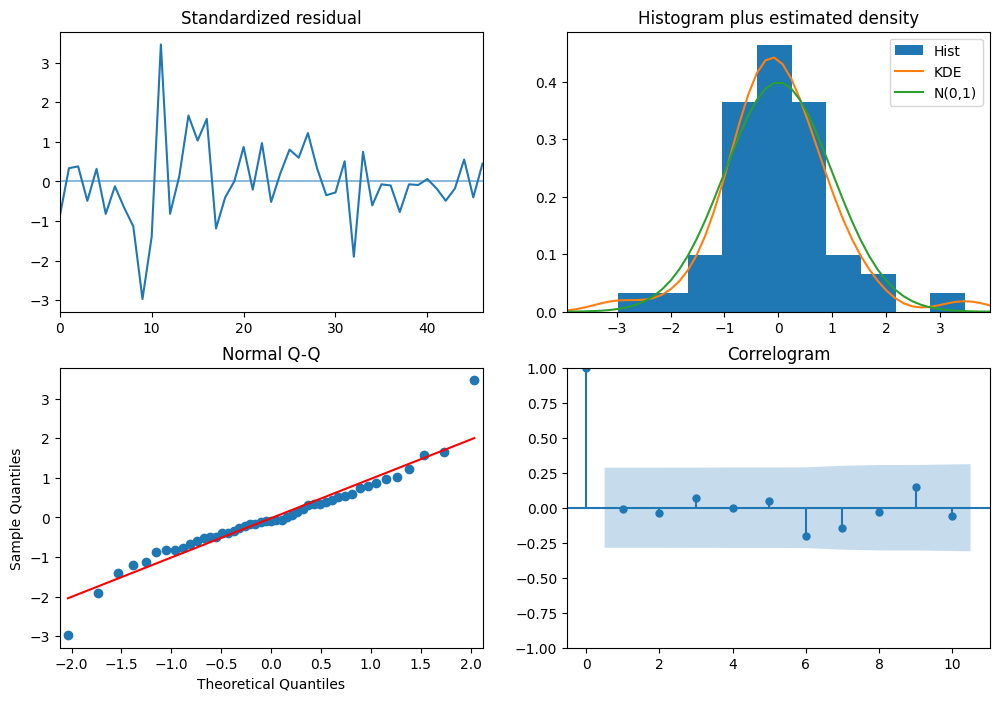

In [133]:
fig = model.plot_diagnostics(figsize=(12, 8))
fig.show()

In [134]:
from sklearn.metrics import mean_squared_error
def plot_sample_1d(model:pm.arima.ARIMA, train:pl.Series, test:pl.Series) -> go.Figure:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
    train_np = train.to_numpy().reshape(-1)
    test_np = test.to_numpy().reshape(-1)
    scaler = MinMaxScaler()
    in_sample = model.predict_in_sample()
    out_of_sample = model.predict(len(test))
    train_xs = np.arange(len(train))
    test_xs = np.arange(len(train), len(train)+len(test))
    test_s = scaler.fit_transform(test_np.reshape(-1,1)).reshape(-1) 
    
    out_of_sample_s = scaler.fit_transform(out_of_sample.reshape(-1,1)).reshape(-1)
    RMSE = mean_squared_error(test_s, out_of_sample_s)

    fig = go.Figure() 
    fig.add_trace(go.Scatter(x=train_xs, y=train_np, mode="markers", name="Train"))
    fig.add_trace(go.Scatter(x=train_xs[1:], y=in_sample[1:], mode="markers", name="In-sample Prediction"))
    fig.add_trace(go.Scatter(x=test_xs,  y=test_np, mode="markers", name="Test"))
    fig.add_trace(go.Scatter(x=test_xs,  y=out_of_sample, mode="markers", name=f"Out-of-sample Prediction (RMSE={RMSE})"))

    return fig

In [135]:
def plot_sample_2d(model_x: pm.arima.ARIMA, model_y: pm.arima.ARIMA,
                   train_x: pl.Series, train_y: pl.Series,
                   test_x: pl.Series, test_y: pl.Series) -> go.Figure:
    train_x_np = train_x.to_numpy().reshape(-1)
    train_y_np = train_y.to_numpy().reshape(-1)
    test_x_np = test_x.to_numpy().reshape(-1)
    test_y_np = test_y.to_numpy().reshape(-1)

    in_sample_x = model_x.predict_in_sample()
    in_sample_y = model_y.predict_in_sample()
    out_of_sample_x = model_x.predict(len(test_x))
    out_of_sample_y = model_y.predict(len(test_y))

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_x_np, y=train_y_np, mode="markers", name="Train"))
    fig.add_trace(go.Scatter(x=in_sample_x[1:], y=in_sample_y[1:], mode="markers", name="In-sample Prediction"))
    fig.add_trace(go.Scatter(x=test_x_np, y=test_y_np, mode="markers", name="Test"))
    fig.add_trace(go.Scatter(x=out_of_sample_x, y=out_of_sample_y, mode="markers", name="Out-of-sample Prediction"))

    fig.update_layout(
        title="2D Scatter Plot",
        xaxis_title="X",
        yaxis_title="Y",
        legend_title="Data Points",
        yaxis=dict(scaleanchor="x", scaleratio=1),
    )

    return fig

In [136]:
lat = cast(pl.Series, df_sample.select("latitude"))
lon = cast(pl.Series, df_sample.select("longitude"))
model_x, train_x, test_x = create_model(lon)
model_y, train_y, test_y = create_model(lat)
fig = plot_sample_2d(model_x, model_y, train_x, train_y, test_x, test_y)

In [137]:
fig.update_layout(
    width=1000,
    height=600,
    title="latitude & longitude",
    xaxis_title="latitude",
    yaxis_title="longitude",
)
fig.show()

In [138]:
wind_speed_pred = cast(pl.Series, df_sample.select("wind_speed"))
model_w, train_w, test_w = create_model(wind_speed_pred)
fig_w = plot_sample_1d(model_w, train_w, test_w)
fig_w.update_layout(
    title="Wind Speed",
    yaxis_title="Wind Speed (m/s)",
)
fig_w.show()

In [139]:
lowest_pressure_pred = cast(pl.Series, df_sample.select("lowest_pressure"))
model_p, train_p, test_p = create_model(lowest_pressure_pred)
fig_p = plot_sample_1d(model_p, train_p, test_p)
fig_p.update_layout(
    title="Lowest Pressure",
    yaxis_title="Lowest Pressure (hPa)",
)
fig_p.show()

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(df: pl.DataFrame, lags_acf=240, lags_pacf=40, figsize=(18, 12)):
    fig, axes = plt.subplots(len(df.columns), 6, figsize=figsize)

    # 遍历每个特征，并在相应的子图中绘制ACF和PACF图
    for i, col_s in enumerate(df.columns):
        # 绘制原始序列的ACF和PACF图
        col_ = df.select(col_s)
        col = col_.to_numpy().reshape(-1)
        lags_acf_ = min(lags_acf, len(col)-2)
        lags_pacf_ = min(lags_pacf, len(col)-2)
        plot_acf(col, ax=axes[i, 0], lags=lags_acf_)
        axes[i, 0].set_title(f'ACF - {col_s}')
        plot_pacf(col, ax=axes[i, 1], lags=lags_pacf_)
        axes[i, 1].set_title(f'PACF - {col_s}')
        
        # 计算一阶差分和二阶差分
        diff1 = np.diff(col)
        diff2 = np.diff(diff1)
        
        # 绘制一阶差分的ACF和PACF图
        lags_diff1 = min(lags_pacf, len(diff1) - 1)
        plot_acf(diff1, ax=axes[i, 2], lags=lags_diff1)
        axes[i, 2].set_title(f'ACF - {col_s} (1st Diff)')
        plot_pacf(diff1, ax=axes[i, 3], lags=lags_diff1)
        axes[i, 3].set_title(f'PACF - {col_s} (1st Diff)')
        
        # 绘制二阶差分的ACF和PACF图
        lags_diff2 = min(lags_pacf, len(diff2) - 1)
        plot_acf(diff2, ax=axes[i, 4], lags=lags_diff2)
        axes[i, 4].set_title(f'ACF - {col_s} (2nd Diff)')
        plot_pacf(diff2, ax=axes[i, 5], lags=lags_diff2)
        axes[i, 5].set_title(f'PACF - {col_s} (2nd Diff)')

    # 调整子图之间的间距
    plt.tight_layout()
    return fig

/tmp/ipykernel_106584/1603787271.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



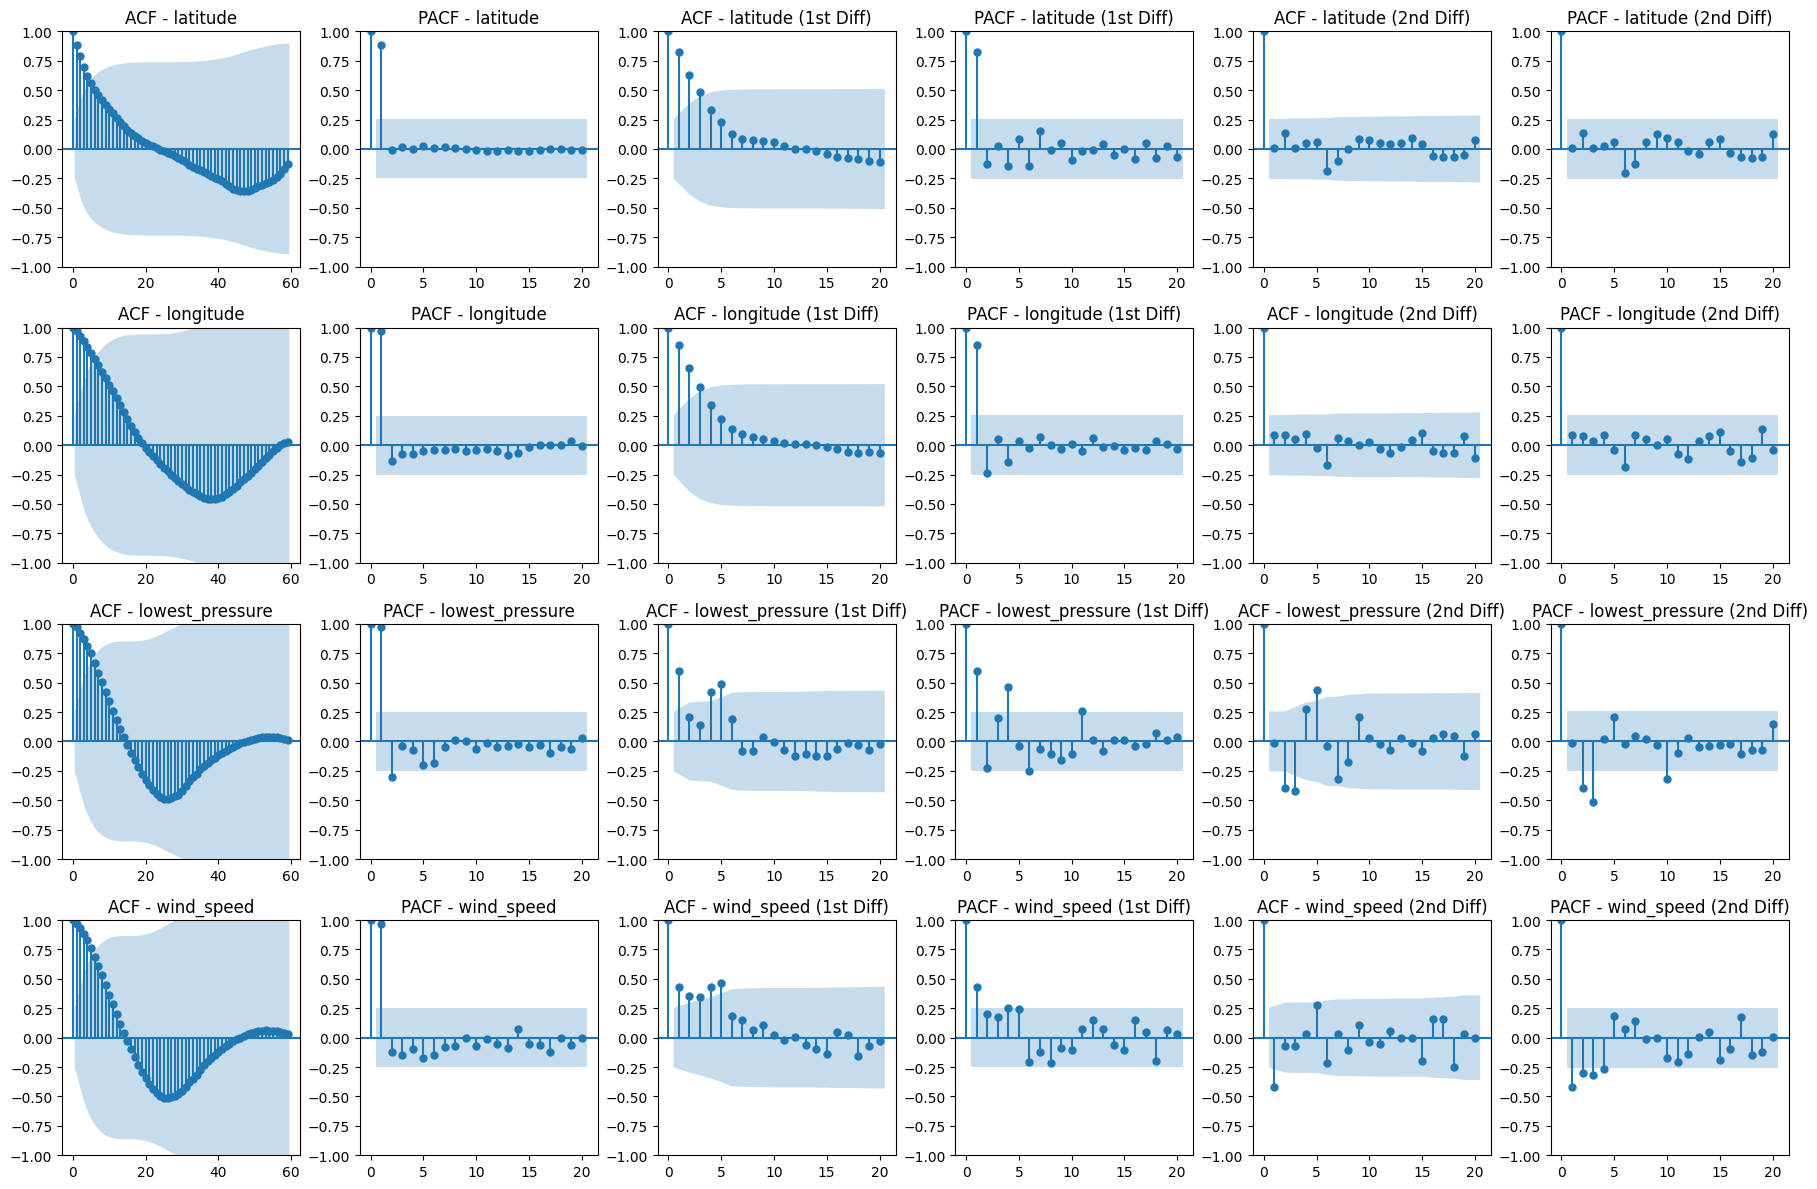

In [141]:
fig = plot_acf_pacf(
    df_sample.select([
        "latitude",
        "longitude",
        "lowest_pressure",
        "wind_speed",
    ]), lags_pacf=20)
fig.savefig("result.png")
fig.show()

In [142]:
display(model_x.summary())
display(model_y.summary())
display(model_w.summary())
display(model_p.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -15.312
Date:                Thu, 25 Apr 2024   AIC                             36.623
Time:                        01:57:57   BIC                             42.174
Sample:                             0   HQIC                            38.712
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1637      0.068     -2.398      0.016      -0.297      -0.030
ar.L1          0.7018      0.082      8.513      0.000       0.540       0.863
sigma2         0.1107      0.016      6.772      0.000       0.079       0.143
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                33.59
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  -2.841
Date:                Thu, 25 Apr 2024   AIC                             17.682
Time:                        01:57:57   BIC                             28.783
Sample:                             0   HQIC                            21.859
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0323      0.043      0.757      0.449      -0.051       0.116
ar.L1          1.5143      0.149     10.193      0.000       1.223       1.805
ar.L2         -0.6160      0.192     -3.212      0.001      -0.992      -0.240
ma.L1         -0.7829      0.350     -2.239      0.025      -1.468      -0.098
ma.L2         -0.1777      0.364     -0.488      0.625      -0.891       0.536
sigma2         0.0648      0.019      3.332      0.001       0.027       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.30
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -114.563
Date:                Thu, 25 Apr 2024   AIC                            233.127
Time:                        01:57:57   BIC                            236.827
Sample:                             0   HQIC                           234.519
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5385      0.108      4.992      0.000       0.327       0.750
sigma2         7.6131      1.302      5.849      0.000       5.062      10.164
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.69   Prob(JB):                         0.27
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -132.953
Date:                Thu, 25 Apr 2024   AIC                            279.906
Time:                        01:57:57   BIC                            292.857
Sample:                             0   HQIC                           284.779
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6477      0.154      4.217      0.000       0.347       0.949
ma.L1          0.1710      0.207      0.827      0.409      -0.235       0.577
ma.L2         -0.0529      0.154     -0.343      0.732      -0.355       0.249
ma.L3         -0.3162      0.154     -2.059      0.039      -0.617      -0.015
ma.L4          0.2718      0.128      2.121      0.034       0.021       0.523
ma.L5          0.5439      0.173      3.147      0.002       0.205       0.883
sigma2        15.5351      4.082      3.806      0.000       7.535      23.535
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.53   Prob(JB):                         0.32
Heteroskedasticity (H):              13.53   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""